- 训练深层神经网络是十分困难的，特别是在较短的时间内使他们收敛更加棘手。
- 本节将介绍批量规范化（batch normalization）(Ioffe and Szegedy, 2015)，这是一种流行且有效的技术，可持续加速深层网络的收敛速度。
- 再结合在 7.6节中将介绍的残差块，批量规范化使得研究人员能够训练100层以上的网络。
为什么需要批量规范化层呢？让我们来回顾一下训练神经网络时出现的一些实际挑战。
- 首先，数据预处理的方式通常会对最终结果产生巨大影响。回想一下我们应用多层感知机来预测房价的例子（4.10节）。使用真实数据时，我们的第一步是标准化输入特征，使其平均值为0，方差为1。直观地说，这种标准化可以很好地与我们的优化器配合使用，因为它可以将参数的量级进行统一。
- 第二，对于典型的多层感知机或卷积神经网络。当我们训练时，中间层中的变量（例如，多层感知机中的仿射变换输出）可能具有更广的变化范围：不论是沿着从输入到输出的层，跨同一层中的单元，或是随着时间的推移，模型参数的随着训练更新变幻莫测。批量规范化的发明者非正式地假设，这些变量分布中的这种偏移可能会阻碍网络的收敛。直观地说，我们可能会猜想，如果一个层的可变值是另一层的100倍，这可能需要对学习率进行补偿调整。
- 第三，更深层的网络很复杂，容易过拟合。这意味着正则化变得更加重要。批量规范化应用于单个可选层（也可以应用到所有层），其原理如下：在每次训练迭代中，我们首先规范化输入，即通过减去其均值并除以其标准差，其中两者均基于当前小批量处理。接下来，我们应用比例系数和比例偏移。正是由于这个基于批量统计的标准化，才有了批量规范化的名称。
估计值 ˆμB和 ˆσB通过使用平均值和方差的噪声（noise）估计来抵消缩放问题。乍看起来，这种噪声是一个问题，而事实上它是有益的。由于尚未在理论上明确的原因，优化中的各种噪声源通常会导致更快的训练和较少的过拟合：这种变化似乎是正则化的一种形式。在一些初步研究中，(Teye et al.,2018)和 (Luo et al., 2018)分别将批量规范化的性质与贝叶斯先验相关联。这些理论揭示了为什么批量规范化最适应50 ∼ 100范围中的中等批量大小的难题。

批量规范化和其他层之间的一个关键区别是，由于批量规范化在完整的小批量上运行，因此我们
不能像以前在引入其他层时那样忽略批量大小。我们在下面讨论这两种情况：全连接层和卷积层，他们的批
量规范化实现略有不同。

批量规范化在训练模式和预测模式下的行为通常不同。首先，将训练好的模型用于预
测时，我们不再需要样本均值中的噪声以及在微批次上估计每个小批次产生的样本方差了。其次，例如，我
们可能需要使用我们的模型对逐个样本进行预测。一种常用的方法是通过移动平均估算整个训练数据集的样
本均值和方差，并在预测时使用它们得到确定的输出。

In [5]:
import torch
from torch import nn
from d2l import torch as d2l

def batch_norm(X,gamma,beta,moving_mean,moving_var,eps,momentum):
    #通过is_grad_enabled来判断当前模式是训练模式还是预测模式
    if not torch.is_grad_enabled():
        #如果是在预测模式下，直接使用传入的移动平均所得的均值和方差
        X_hat=(X-moving_mean)/torch.sqrt(moving_var+eps)
    else:
        assert len(X.shape) in (2,4)
        if len(X.shape)==2:
            #使用全连接层的情况，计算特征维度上的均值和方差
            mean=X.mean(dim=0)
            var=((X-mean)**2).mean(dim=0)
        else:
            #使用二维卷积层的情况，计算通道维上（axis=1）的均值和方差。
            #这里我们需要保持X的形状以便后面可以做广播运算
            mean=X.mean(dim=(0,2,3),keepdim=True)
            var=((X-mean)**2).mean(dim=(0,2,3),keepdim=True)
        #训练模式下，用当前的均值和方差做标准化
        X_hat=(X-mean)/torch.sqrt(var+eps)
        #更新移动平均的均值和方差
        moving_mean=momentum*moving_mean+(1.0-momentum)*mean
        moving_var=momentum*moving_var+(1.0-momentum)*var
    Y=gamma*X_hat+beta      #缩放和移位
    return Y,moving_mean.data,moving_var.data

我们现在可以创建一个正确的BatchNorm层。这个层将保持适当的参数：拉伸gamma和偏移beta,这两个参数将在训练过程中更新。此外，我们的层将保存均值和方差的移动平均值，以便在模型预测期间随后使用。

In [6]:
class BatchNorm(nn.Module):
    # num_features：完全连接层的输出数量或卷积层的输出通道数。
    # num_dims：2表示完全连接层，4表示卷积层
    def __init__(self, num_features, num_dims):
        super().__init__()
        if num_dims == 2:
            shape = (1, num_features)
        else:
            shape = (1, num_features, 1, 1)
        # 参与求梯度和迭代的拉伸和偏移参数，分别初始化成1和0
        self.gamma = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.zeros(shape))
        # 非模型参数的变量初始化为0和1
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.ones(shape)
        
    def forward(self, X):
        # 如果X不在内存上，将moving_mean和moving_var
        # 复制到X所在显存上
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
        # 保存更新过的moving_mean和moving_var
        Y, self.moving_mean, self.moving_var = batch_norm(
            X, self.gamma, self.beta, self.moving_mean,
            self.moving_var, eps=1e-5, momentum=0.9)
        return Y

In [7]:
#用BN规范化LeNet:
#批量规范化是在卷积层或全连接层之后、相应的激活函数之前应用的。
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), BatchNorm(6, num_dims=4), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), BatchNorm(16, num_dims=4), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2), nn.Flatten(),
    nn.Linear(16*4*4, 120), BatchNorm(120, num_dims=2), nn.Sigmoid(),
    nn.Linear(120, 84), BatchNorm(84, num_dims=2), nn.Sigmoid(),
    nn.Linear(84, 10))

loss 0.239, train acc 0.911, test acc 0.884
41976.0 examples/sec on cuda:0


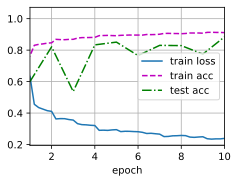

In [10]:
#和以前一样，我们将在Fashion‐MNIST数据集上训练网络。这个代码与我们第一次训练LeNet（6.6节）时几乎完全相同，主要区别在于学习率大得多。
lr,num_epochs,batch_size=1.0,10,256
train_iter,test_iter=d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch6(net,train_iter,test_iter,num_epochs,lr,d2l.try_gpu())

In [11]:
#让我们来看看从第一个批量规范化层中学到的拉伸参数gamma和偏移参数beta:
net[1].gamma.reshape((-1,)), net[1].beta.reshape((-1,))

(tensor([3.3012, 2.6709, 4.3534, 5.0848, 2.5444, 4.0480], device='cuda:0',
        grad_fn=<ViewBackward0>),
 tensor([ 1.2341, -4.1338,  3.2854,  5.1670,  4.5857,  4.1902], device='cuda:0',
        grad_fn=<ViewBackward0>))

In [12]:
#BN的简明实现：我们也可以直接使用深度学习框架中定义的BatchNorm
net=nn.Sequential(
    nn.Conv2d(1,6,kernel_size=5),nn.BatchNorm2d(6),nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2,stride=2),
    nn.Conv2d(6,16,kernel_size=5),nn.BatchNorm2d(16),nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2), nn.Flatten(),
    nn.Linear(256, 120), nn.BatchNorm1d(120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.BatchNorm1d(84), nn.Sigmoid(),
    nn.Linear(84, 10))

loss 0.263, train acc 0.904, test acc 0.832
58776.8 examples/sec on cuda:0


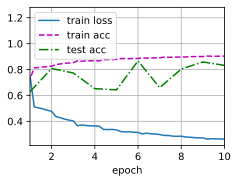

In [13]:
#下面，我们使用相同超参数来训练模型。请注意，通常高级API变体运行速度快得多，因为它的代码已编译为C++或CUDA，而我们的自定义代码由Python实现。
d2l.train_ch6(net,train_iter,test_iter,num_epochs,lr,d2l.try_gpu())

争议：

直观地说，批量规范化被认为可以使优化更加平滑。然而，我们必须小心区分直觉和对我们观察到的现象的真实解释。回想一下，我们甚至不知道简单的神经网络（多层感知机和传统的卷积神经网络）为什么如此有效。即使在暂退法和权重衰减的情况下，它们仍然非常灵活，因此无法通过常规的学习理论泛化保证来解释它们是否能够泛化到看不见的数据。

在提出批量规范化的论文中，作者除了介绍了其应用，还解释了其原理：通过减少内部协变量偏移（internalcovariate shift）。据推测，作者所说的内部协变量转移类似于上述的投机直觉，即变量值的分布在训练过程中会发生变化。然而，这种解释有两个问题：
1、这种偏移与严格定义的协变量偏移（covariate shift）非常不同，所以这个名字用词不当；
2、这种解释只提供了一种不明确的直觉，但留下了一个有待后续挖掘的问题：为什么这项技术如此有效？本书旨在传达实践者用来发展深层神经网络的直觉。然而，重要的是将这些指导
性直觉与既定的科学事实区分开来。最终，当你掌握了这些方法，并开始撰写自己的研究论文时，你会希望清楚地区分技术和直觉。

随着批量规范化的普及，内部协变量偏移的解释反复出现在技术文献的辩论，特别是关于“如何展示机器学习研究”的更广泛的讨论中。Ali Rahimi在接受2017年NeurIPS大会的“接受时间考验奖”（Test of TimeAward）时发表了一篇令人难忘的演讲。他将“内部协变量转移”作为焦点，将现代深度学习的实践比作炼金术。他对该示例进行了详细回顾 (Lipton and Steinhardt, 2018)，概述了机器学习中令人不安的趋势。此外，一些作者对批量规范化的成功提出了另一种解释：在某些方面，批量规范化的表现出与原始论文 (Santurkaret al., 2018)中声称的行为是相反的。

然而，与机器学习文献中成千上万类似模糊的说法相比，内部协变量偏移没有更值得批评。很可能，它作为这些辩论的焦点而产生共鸣，要归功于目标受众对它的广泛认可。批量规范化已经被证明是一种不可或缺的方法。它适用于几乎所有图像分类器，并在学术界获得了数万引用。

小结
- 在模型训练过程中，批量规范化利用小批量的均值和标准差，不断调整神经网络的中间输出，使整个神经网络各层的中间输出值更加稳定。
- 批量规范化在全连接层和卷积层的使用略有不同。
- 批量规范化层和暂退层一样，在训练模式和预测模式下计算不同。
- 批量规范化有许多有益的副作用，主要是正则化。另一方面，”减少内部协变量偏移“的原始动机似乎不是一个有效的解释。